# Imports and Moving into Directory

In [1]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import os

If using Google Colab run the following code block

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

#Move to the notebook working directory
%cd /content/gdrive/MyDrive/Bioimage\ Informatics/Tracking

!pip install pims_nd2

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1KBLLeRYGQsIfkELFrExLiWHh1WVbHC7P/Bioimage Informatics/Tracking
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Created wheel for pims-nd2: filename=pims_nd2-1.1-py3-none-any.whl size=19778399 sha256=01572f7d5ec465dbe10918cfcfee921e8609f8d6c65fa21bb88a0a66c74f91cc
  Stored in directory: /root/.cache/pip/wheels/c4/5f/6a/c499ced897d109e21381e12a7acea883ea18fb0001434c0545
  Created wheel for pims: filename=PIMS-0.6.1-py3-none-any.whl size=82636 sha256=a9acbcbc86850b69409f7d100a0a4d9e8181e3f835f6b40cd9d360633b04172b
  Stored in directory: /root/.cache/pip/wheels/8e/d5/a9/f702433436655b7a2bc7ff93efd742587dd5abd44f7e406917
Successfully built pims-nd2 pims


In [3]:
from image_processing import *
from auto_encoder_model import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2146304/45929032 bytes (4.7%)4145152/45929032 bytes (9.0%)6758400/45929032 bytes (14.7%)8749056/45929032 bytes (19.0%)11337728/45929032 bytes (24.7%)13402112/45929032 bytes (29.2%)15638528/45929032 bytes (34.0%)17629184/45929032 bytes (38.4%)20021248/45929032 bytes (43.6%)21733376/45929032 bytes (47.3%)24281088/45929032 bytes (52.9%)26918912/45929032 bytes (58.6%)286

# Moving Image Files around and Testing Droplet Counting Code

In [ ]:
import shutil

dir = '/content/gdrive/MyDrive/Bioimage Informatics/denoise_results/Evan_4_3_1/150 epochs/images'
files = os.listdir(dir)

for f in files:
    if "fake" in f:
        shutil.copy(os.path.join(dir,f),'/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/CycleGAN_Processed_Test_Images')

In [ ]:
trainFolder = '/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/CycleGAN_Processed_Test_Images'
images = read_images_from_dir(trainFolder)

Read in 60 images with each image of shape (256, 256, 3)

The first image from the folder


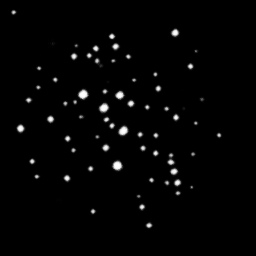

In [ ]:
print(f"Read in {len(images)} images with each image of shape {images[0].shape}\n")

print("The first image from the folder")
cv2_imshow(images[11])

In [8]:
outPath = '/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/Auto_Encoder_Droplet_Images/'

In [ ]:
imgCentroids = []
max = 0 

count = 0
for img in images:

    #detect droplet, store centroid location
    dropletDims, dropletCentroids = detect_droplets(img[:,:,0])

    if np.max(dropletDims[:,0:2]) > max:
        max = np.max(dropletDims[:,0:2])

    imgCentroids.append(dropletCentroids)
    
    #crop each individual droplet , save to file
    dropletImgs = crop_droplets(img[:,:,0], dropletDims,count,outPath,save = True)
    count += len(dropletImgs)

In [ ]:
print(f"The bounding with largest single dimension was of size {max} pixels")

The bounding with largest single dimension was of size 39 pixels


# Training the AutoEncoder

In [9]:
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt

In [10]:
images = []
for f in os.listdir(outPath):

    images.append(cv2.imread(os.path.join(outPath,f),cv2.IMREAD_GRAYSCALE))

In [11]:
#Training config dictionary, k arg is used to determine knn adj matrix 
config = dict(encodingDim = 15,max = 40, batch_size = 32, epochs = 50,
              learning_rate = .01,modelPath = 'trained_model.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
#Split data into train, validation, and test set
X_train, X_test = train_test_split(images,train_size = .8,shuffle = True)
X_train,X_val  = train_test_split(X_train,train_size = .8,shuffle = True)


trainData = DropletImageData(X_train,config['max'])
train_args = dict(shuffle = True, batch_size = 32, num_workers= 8,drop_last = False, pin_memory = False)
train_loader = DataLoader(trainData,**train_args)

valData = DropletImageData(X_val,config['max'])
val_args = dict(shuffle = True, batch_size = 32, num_workers= 8,drop_last = False, pin_memory = False)
val_loader = DataLoader(valData,**val_args)



print("Number of samples in training set:",len(trainData))
print("Number of samples in validation set:",len(valData))

Number of samples in training set: 3158
Number of samples in validation set: 790


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = AutoEncoder(1,config['encodingDim'])
model.to(device)

optim = torch.optim.Adam(model.parameters(),lr = config['learning_rate'])

In [ ]:
trainLoss = []
valLoss = []

with tqdm(range(config["epochs"]), unit= 'epoch') as tepoch:
  for e in tepoch:
      tepoch.set_description(f"Epoch {e}")

      trainLoss.append(train_one_epoch(train_loader,model,optim,device))
      valLoss.append(eval_one_epoch(val_loader,model,device))

      tepoch.set_postfix(train_loss = trainLoss[-1],val_loss = valLoss[-1])

#Save trained model
torch.save(model.state_dict(),config['modelPath'])

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


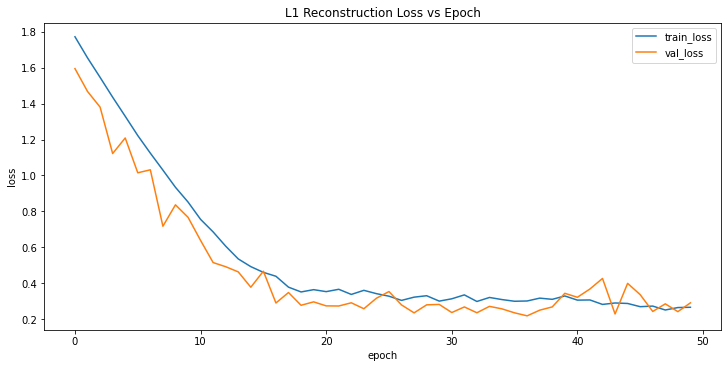

In [ ]:
fig, ax = plt.subplots(1,1, sharex = True,figsize=(10,5),constrained_layout = True)
ax.plot(np.arange(len(trainLoss)),trainLoss,label = "train_loss")
ax.plot(np.arange(len(valLoss)),valLoss,label = "val_loss")
ax.set_title("L1 Reconstruction Loss vs Epoch")
ax.set(ylabel='loss')
ax.set(xlabel='epoch')
ax.legend()

# Qualitative Evaluation of the "Test" Images ie. 60 frame video

In [13]:
testData = DropletImageData(X_test,config['max'])
test_args = dict(shuffle = False, batch_size = 32, num_workers= 8,drop_last = False, pin_memory = False)
test_loader = DataLoader(testData,**test_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
preds = []
imgs = []

model = AutoEncoder(1,config['encodingDim']) 
model.load_state_dict(torch.load(config["modelPath"]))
model.to(device)
model.eval()

for X in test_loader:
    imgs.extend(X.numpy())

    X = X.to(device)
    X = X.unsqueeze(1)
    preds.extend(model(X).squeeze(1).cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


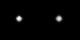

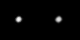

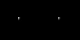

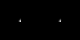

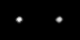

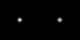

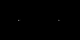

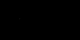

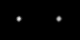

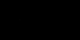

In [16]:
for i in range(10):
    cv2_imshow(np.hstack((imgs[i],preds[i])))

# Network Flow Formulation

In [17]:
import networkx as nx

In [181]:
def add_s_t_self_edges(G,nodes):

    #iterate over the new objects to add 
    for i in nodes:
      G.add_edge('s',f'u_{i}', capacity = 1, weight =  1)
      G.add_edge(f'u_{i}',f'v_{i}',capacity = 1, weight = 1)
      G.add_edge(f'v_{i}','t',capacity = 1, weight = 1) ### the weight here could be an important parameter to play with


In [188]:
def add_fully_connected_edges(G,nodesPre,nodesPost):
    max = 0 

    for i in range(len(nodesPre)):
        for j in range(len(nodesPost)):
            edgeWeight = np.linalg.norm(nodesPre[i] - nodesPost[j])
            G.add_edge(f'v_{i}',f'u_{j}', capacity = 1, weight = edgeWeight)

            if edgeWeight > max:
                max = edgeWeight

    return max

In [183]:
testFolder = '/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/CycleGAN_Processed_Test_Images'
images = read_images_from_dir(testFolder)

print(f"There are {len(images)} frames in the folder")

There are 60 frames in the folder


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoEncoder(1,config['encodingDim']) 
model.load_state_dict(torch.load(config["modelPath"]))
model.to(device)
model.eval()

In [185]:
numDropsPerFrame = np.zeros((60))

In [190]:
#construct directed graph, source and sink nodes
G = nx.DiGraph()
G.add_nodes_from(['s','t'])

count = 0
#Detect droplets, crop, get features from auto encoder, add edges to graph
for i,img in enumerate(images[1:5]):
    
    if i  == 0:
        #detect droplet, store centroid location
        dropletDims, dropletCentroids = detect_droplets(img[:,:,0])

        dropletDimsMat = dropletDims
        numDropsPerFrame[i] = len(dropletDims)
        
        #crop each individual droplet
        dropletImgs = crop_droplets(img[:,:,0], dropletDims,0)

        #set up dataloader because it already has the pad function
        testData = DropletImageData(dropletImgs,config['max'])
        test_args = dict(shuffle = False, batch_size = 1, num_workers= 8,drop_last = False, pin_memory = False)
        test_loader = DataLoader(testData,**test_args)


        #encode the droplet image
        dropletFeaturesPre = []
        for X in test_loader:

            X = X.to(device)
            X = X.unsqueeze(1)
            dropletFeaturesPre.append(model.encoder(X).cpu().detach().numpy().squeeze(0))

        #add s,t, and self edges to directed graph
        print(add_s_t_self_edges(G,np.arange(count,count + len(dropletDims))))
        count += len(dropletDims)


    else:
          #detect droplet, store centroid location
        dropletDims, dropletCentroids = detect_droplets(img[:,:,0])

        dropletDimsMat = np.vstack((dropletDimsMat,dropletDims))
        numDropsPerFrame[i] = len(dropletDims)

        #crop each individual droplet
        dropletImgs = crop_droplets(img[:,:,0], dropletDims,0)

        #set up dataloader because it already has the pad function
        testData = DropletImageData(dropletImgs,config['max'])
        test_args = dict(shuffle = False, batch_size = 1, num_workers= 8,drop_last = False, pin_memory = False)
        test_loader = DataLoader(testData,**test_args)


        #encode the droplet image
        dropletFeaturesPost = []
        for X in test_loader:

            X = X.to(device)
            X = X.unsqueeze(1)
            dropletFeaturesPost.append(model.encoder(X).cpu().detach().numpy().squeeze(0))

        #add s,t, and self edges to directed graph
        weight = add_s_t_self_edges(G,np.arange(count,count + len(dropletDims)))
        add_fully_connected_edges(G,dropletFeaturesPre,dropletFeaturesPost)
        
        if weight > maxDist:

            maxDist = weight
        count += len(dropletDims)
        dropletFeaturesPre = dropletFeaturesPost


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


None
0


TypeError: ignored

In [165]:
solution = nx.max_flow_min_cost(G,'s','t')
solGraph = nx.Graph()

In [166]:
#iterate over every node in the graph
for node in solution:

    #maintain a list of usede eges (node to k)
    edges = [(node,k) for k,v in solution[node].items() if v > 0]
    solGraph.add_edges_from(edges)

In [167]:
sortedNodes = list(G.nodes)
del sortedNodes[0]
del sortedNodes[0]

In [168]:
count

355

In [169]:
c = 0 
trajs = [] 

while c < count:

    node = sortedNodes[0]

    traj = nx.shortest_path(solGraph,node, target = 't')[:-1] #remove sink node
    trajs.append(traj)

    for subNode in traj:
        sortedNodes.remove(subNode)
    
    c += len(traj)/2

In [170]:
trajs[6]

['u_6', 'v_6']